In [1]:
import torch
import torchvision
import os
import sys
import time
import cv2
import numpy as np
import pytorch_grad_cam
import pickle
import json
%matplotlib inline
import matplotlib.pyplot as plt

/home/tathagato/anaconda3/envs/habitat/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_directory = "./../DREYEVE_DATA_OUTPUTS/"
data_path = os.path.join(dataset_directory,"02/data.json")
f = open(data_path)
data = json.load(f)

In [25]:
def load_RGB(img_path):
    img = cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_UNCHANGED),cv2.COLOR_BGR2RGB)
    return img
def load_gray(img_path):
    return cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
def get_images(dataset, video_index, image_index):
    
    video_name = str(video_index)
    if video_index <= 9:
        video_name = "0" + str(video_index)
    video_directory = os.path.join(dataset,video_name)
    image_directory = os.path.join(video_directory, str(image_index))
    mask = load_gray(os.path.join(image_directory,"mask.jpg"))
    final = load_RGB(os.path.join(image_directory,"final.jpg"))
    box = load_RGB(os.path.join(image_directory,"box.jpg"))
    garmin_directory = os.path.join(video_directory, "garmin")
    saliency_directory = os.path.join(video_directory, "saliency")
    #print(dataset, video_directory, image_directory, garmin_directory, saliency_directory)
    garmin_image = load_RGB(os.path.join(garmin_directory,str(image_index) + ".jpg"))
    saliency_image = cv2.cvtColor(cv2.imread(os.path.join(saliency_directory,str(image_index) + ".jpg"),cv2.IMREAD_UNCHANGED),cv2.COLOR_BGR2GRAY)
    #print(saliency_image.shape)
    print(mask.shape)
    print(mask.min(),mask.max())
    mask = mask / mask.max()
    print(mask.dtype)
    mask = mask.astype(np.float32)
    #mask = saliency_image.astype(np.float32) / 255
    #mask = saliency_image.astype(np.float32)
    #print(saliency_image.max(),saliency_image.min())
    return final,box,mask,garmin_image,saliency_image
def show_images(images):
    d = len(images) // 2
    if len(images) % 2 == 1:
        d += 1
    fig = plt.figure(figsize = (40,40))
    cnt = 1
    for i in range(len(images)):
        #print(d,2,cnt)
        
        fig.add_subplot(d,2,cnt)
        cnt += 1
        img = images[i]
        print(img.shape)
        print(img.max(),img.min())
        if len(img.shape) == 2:
            plt.imshow(img,cmap = 'gray')
        else:
            plt.imshow(img)
    
    
    

(270, 480)
0 2
float64
(270, 480, 3)
255 0
(270, 480, 3)
255 0
(270, 480)
1.0 0.0
(540, 960, 3)
255 0
(540, 960)
255 0


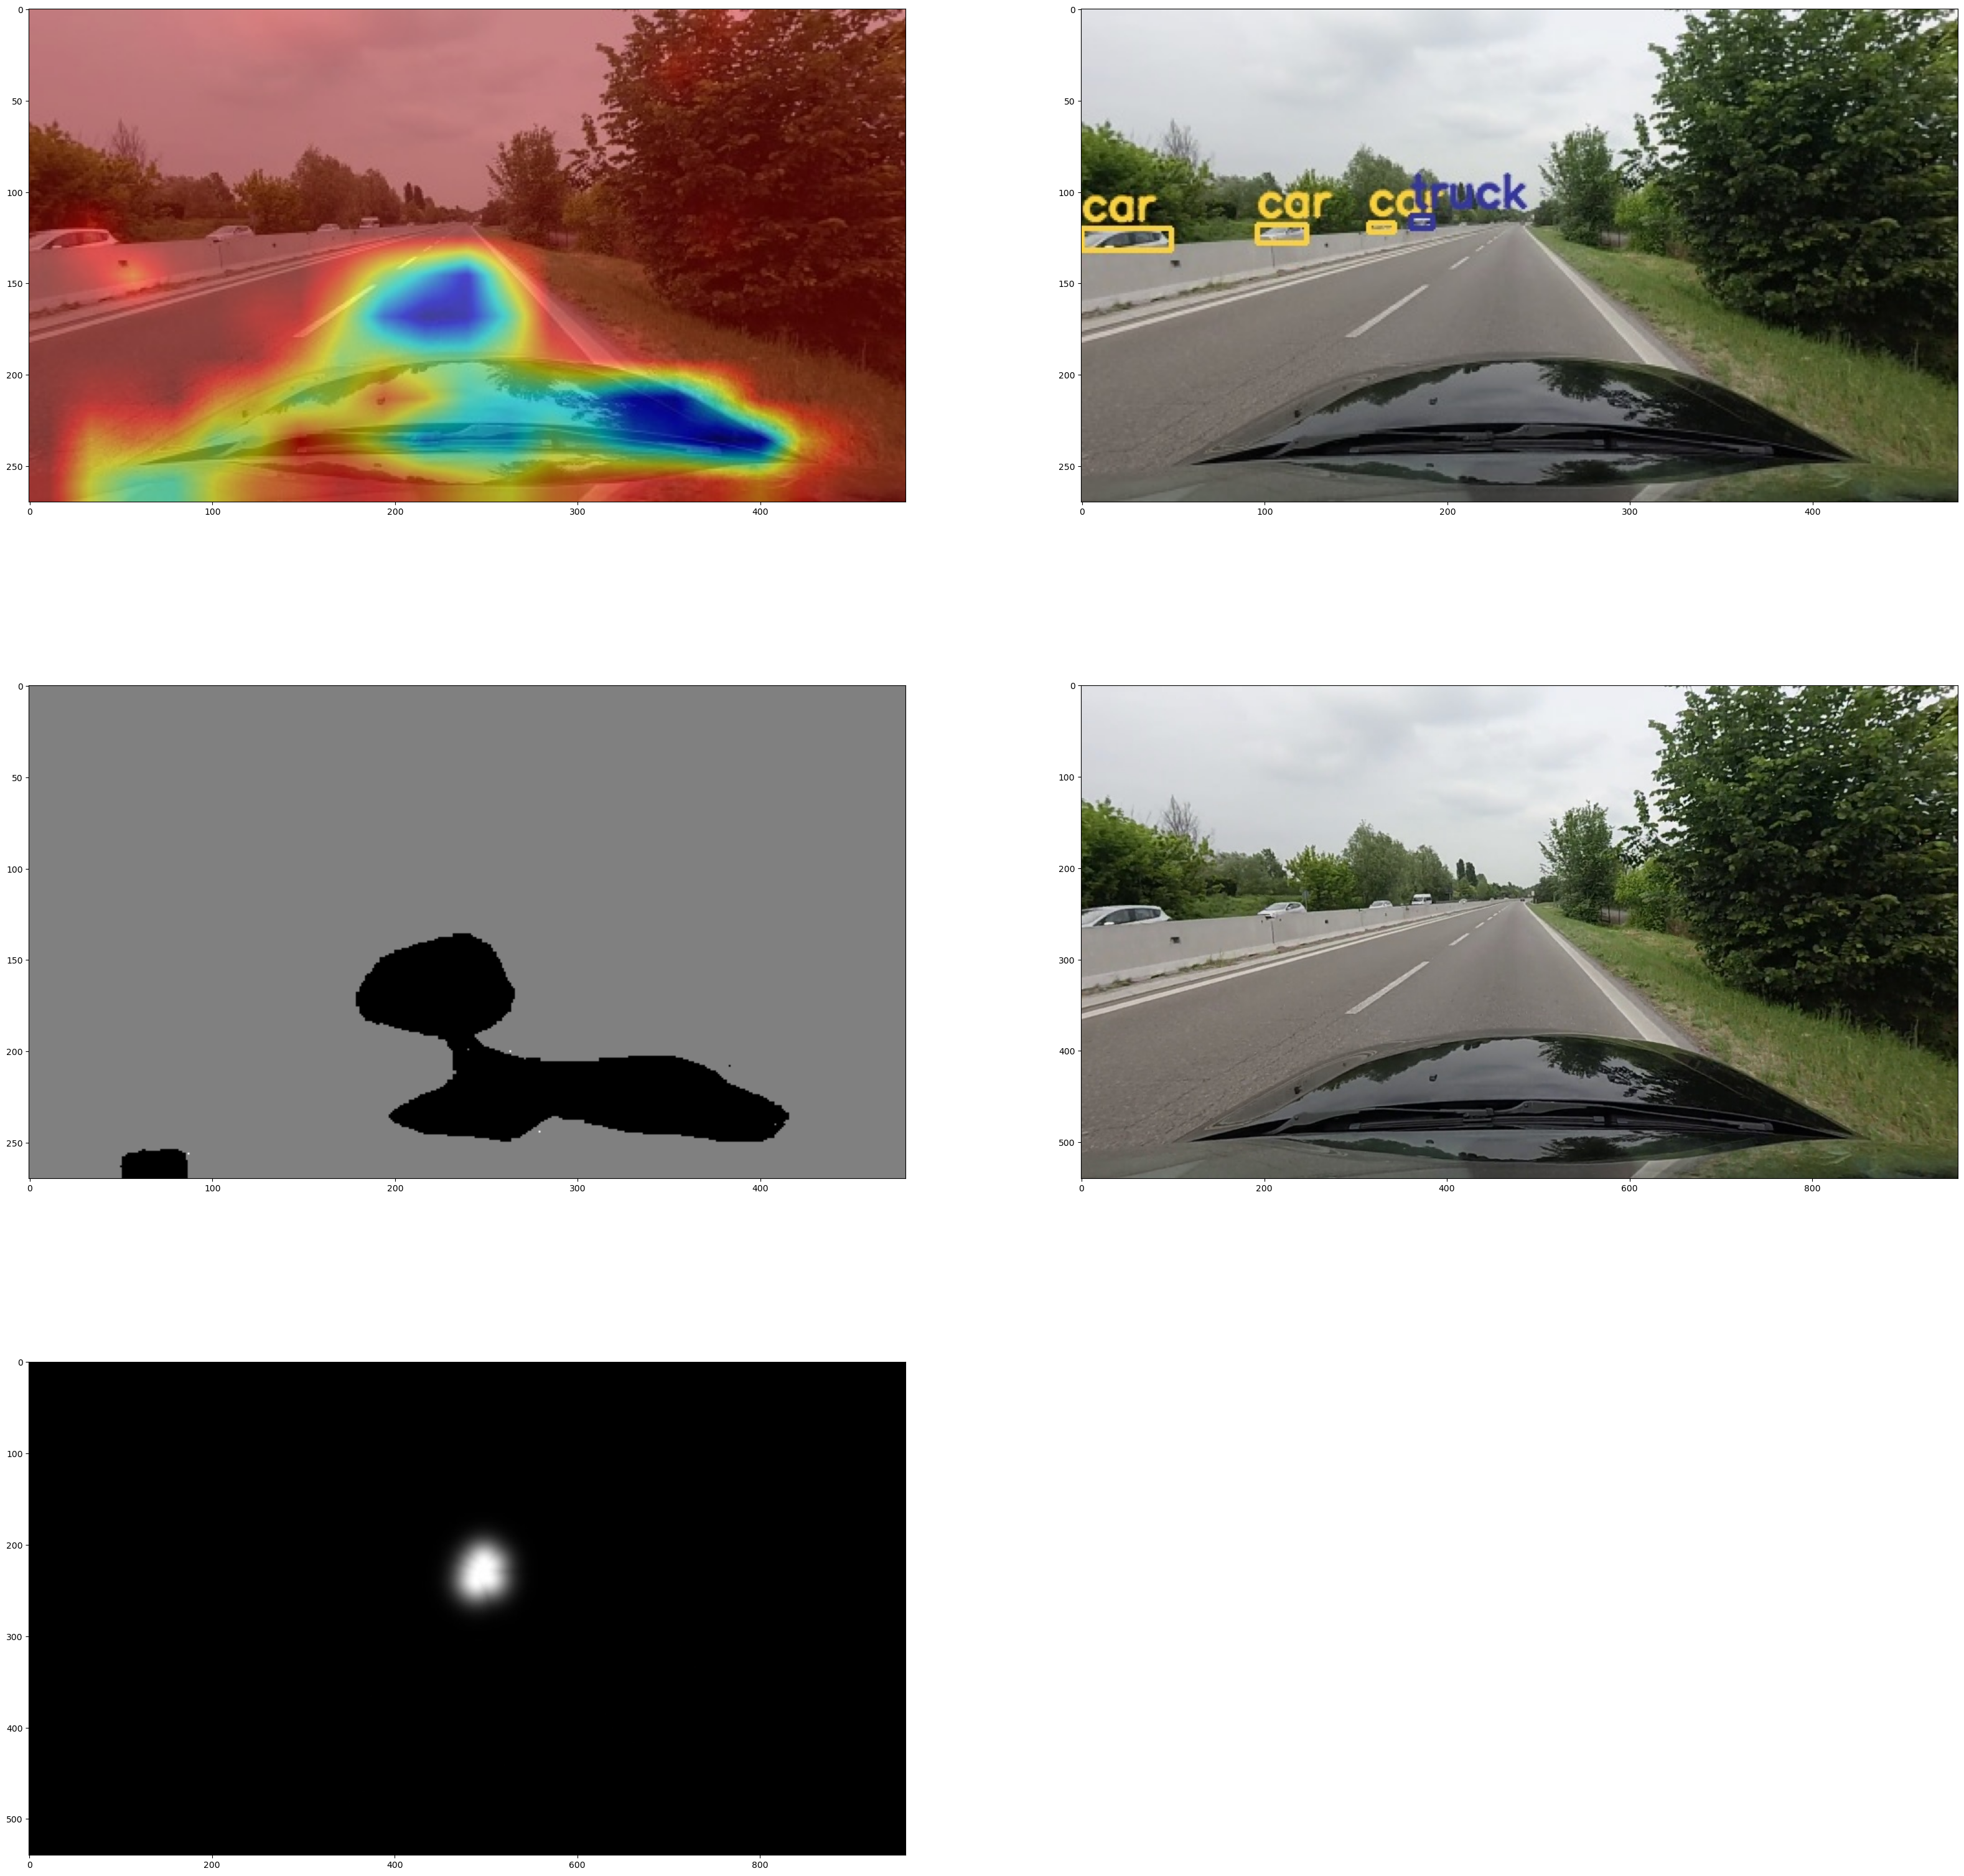

In [26]:
a,b,c,d,e = get_images(dataset_directory,2,190)
show_images([a,b,c,d,e])

In [10]:
for key in data.keys():
    image_obj = data[key]
    print("image_index : {0}, the number of objects is {1}".format(key,image_obj["size"]))


image_index : 0, the number of objects is 1
image_index : 5, the number of objects is 1
image_index : 10, the number of objects is 1
image_index : 15, the number of objects is 0
image_index : 20, the number of objects is 1
image_index : 25, the number of objects is 0
image_index : 30, the number of objects is 0
image_index : 35, the number of objects is 1
image_index : 40, the number of objects is 1
image_index : 45, the number of objects is 0
image_index : 50, the number of objects is 2
image_index : 55, the number of objects is 1
image_index : 60, the number of objects is 3
image_index : 65, the number of objects is 2
image_index : 70, the number of objects is 3
image_index : 75, the number of objects is 3
image_index : 80, the number of objects is 3
image_index : 85, the number of objects is 2
image_index : 90, the number of objects is 1
image_index : 95, the number of objects is 0
image_index : 100, the number of objects is 2
image_index : 105, the number of objects is 0
image_inde

(540, 960, 3)
255 0
(540, 960, 3)
255 0
(540, 960, 3)
1.0 0.0
(540, 960)
0.9999999 0.0
(540, 960, 3)
255 0
(540, 960, 3)
255 0


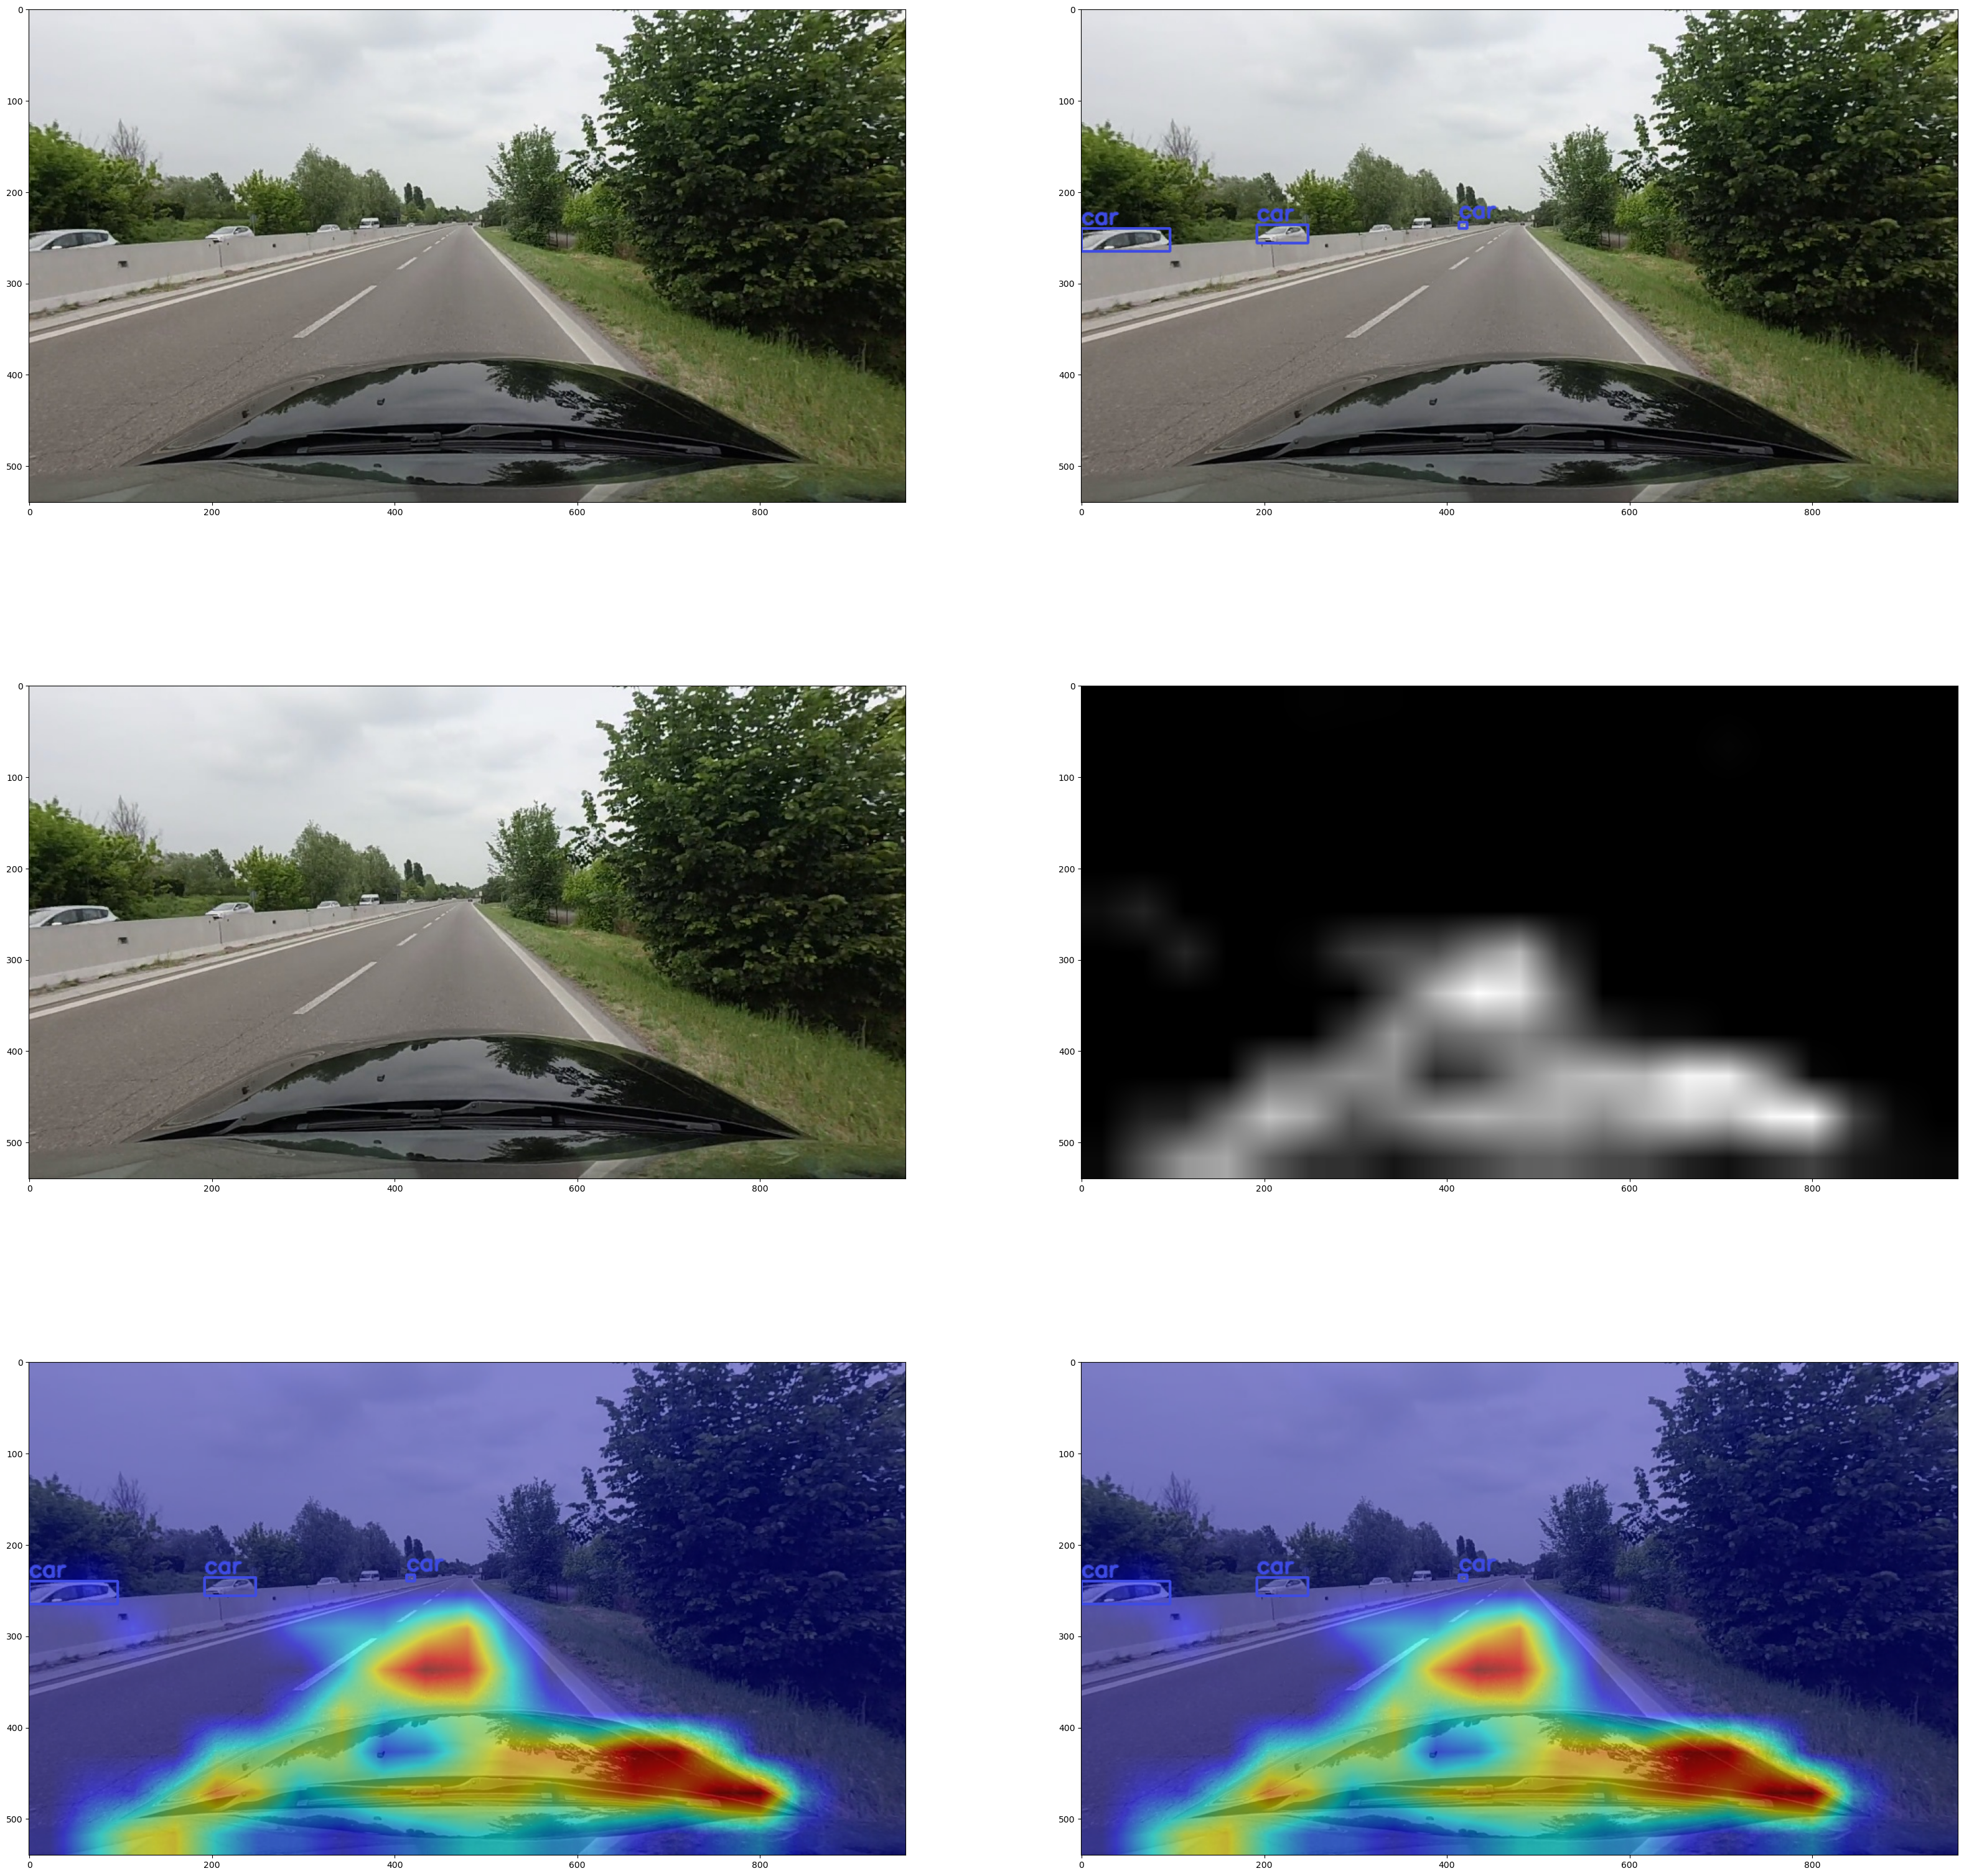

In [28]:
coco_names = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', \
              'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 
              'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 
              'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella',
              'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
              'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
              'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork',
              'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
              'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
              'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet',
              'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
              'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase',
              'scissors', 'teddy bear', 'hair drier', 'toothbrush']
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import cv2
import numpy as np
import torch
import torchvision
from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image
img = d
def predict(input_tensor, model, device, detection_threshold):
    outputs = model(input_tensor)
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    
    boxes, classes, labels, indices = [], [], [], []
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            boxes.append(pred_bboxes[index].astype(np.int32))
            classes.append(pred_classes[index])
            labels.append(pred_labels[index])
            indices.append(index)
    boxes = np.int32(boxes)
    return boxes, classes, labels, indices

def draw_boxes(boxes, labels, classes, image):
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1] - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return image




# This will help us create a different color for each class
#COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))
#image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
image = np.copy(img) 
image_float_np = np.float32(image) / 255
# define the torchvision image transforms
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

input_tensor = transform(image)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")
input_tensor = input_tensor.to(device)
# Add a batch dimension:
input_tensor = input_tensor.unsqueeze(0)

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval().to(device)

# Run the model and display the detections
boxes, classes, labels, indices = predict(input_tensor, model, device, 0.9)
image = draw_boxes(boxes, labels, classes, image)

# Show the image:
target_layers = [model.backbone]
targets = [FasterRCNNBoxScoreTarget(labels=labels, bounding_boxes=boxes)]
cam = EigenCAM(model,
               target_layers, 
               use_cuda=torch.cuda.is_available(),
               reshape_transform=fasterrcnn_reshape_transform)

grayscale_cam = cam(input_tensor, targets=targets)
# Take the first image in the batch:
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
# And lets draw the boxes again:
image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)
show_images([img,image,image_float_np,grayscale_cam, cam_image,image_with_bounding_boxes])


In [30]:
print(grayscale_cam.max(),grayscale_cam.min())
print(grayscale_cam.dtype)

0.9999999 0.0
float32
